In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import random

# --- V7.0 绘图美学配置 (Aesthetic Setup) ---
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei'] # 适配中英文
plt.rcParams['axes.unicode_minus'] = False

try:
    import scienceplots
    plt.style.use(['science', 'no-latex']) # 学术风格
except ImportError:
    # 降级方案：使用 Seaborn 优化
    sns.set_theme(style="whitegrid", palette="deep", context="paper")

class Graph_Solver_Capsule:
    def __init__(self, name="Graph_Model", is_directed=False):
        """
        [MCM Graph Solver V7.0 - Final Version]
        架构: 1.Audit -> 2.Metrics -> 3.Deep Analysis -> 4.Auto-Delivery
        """
        self.name = name
        self.is_directed = is_directed
        self.timestamp = int(time.time())
        self.G = None
        
        # 结果存储容器
        self.node_metrics = pd.DataFrame()
        self.robustness_log = {} # 记录攻击测试的关键结论
        
        # 自动创建输出目录
        self.output_dir = f"./Results_{name}_{self.timestamp}"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    # ======================================================
    # Phase 0: 握手与协议 (Setup & Handshake)
    # ======================================================
    def generate_handshake(self, df_dict=None):
        print(f"\n🤝 === 复制以下 Prompt 发送给 AI (V7.0 Graph) ===\n")
        print(f"【系统设定】\n我正在使用 `Graph_Solver_Capsule` (V7.0)。")
        print(f"图类型: {'有向图 (DiGraph)' if self.is_directed else '无向图 (Graph)'}。")
        print(f"输出目录: `{self.output_dir}`")
        
        print("\n【API 接口清单】")
        print("1. 构建: solver.build_from_edgelist(df, source='S', target='T', weight='W')")
        print("2. 自检: solver.audit() # 必须执行，逻辑自检")
        print("3. 指标: solver.compute_centrality()")
        print("4. [核武器] 社团: solver.detect_communities(method='louvain')")
        print("5. [核武器] 鲁棒性: solver.analyze_robustness(attack_type='targeted', fraction=0.3)")
        print("6. [可视化] 绘图: solver.plot_network(layout='kamada_kawai')")
        print("7. [交付] 导出: solver.export_results() # 生成全套交付物")
        
        print("\n【⚠️ 必须注意的图论陷阱】")
        print("1. **负权边 (Negative Weights)**: 如存在，Dijkstra 失效，请提示使用 Bellman-Ford。")
        print("2. **连通性 (Connectivity)**: 若图不连通，Global Efficiency 无物理意义。建议提取 LCC (Largest Connected Component)。")
        print("3. **强/弱连通**: 有向图中请区分 Strong (双向可达) vs Weak (忽略方向)。")
        
        if df_dict:
            print("\n【数据摘要】")
            for name, df in df_dict.items():
                print(f"Dataset '{name}': {list(df.columns)} | Rows: {len(df)}")

    # ======================================================
    # Phase 1: 构建与自检 (Build & Audit)
    # ======================================================
    def build_from_edgelist(self, df, source, target, weight=None):
        print(f"\n🏗️ 正在构建网络...")
        create_using = nx.DiGraph() if self.is_directed else nx.Graph()
        
        try:
            # 自动处理列名空格问题
            self.G = nx.from_pandas_edgelist(df, source=source, target=target, edge_attr=weight, create_using=create_using)
        except Exception as e:
            print(f"❌ 构建失败: {e}")
            return

        print(f"✅ 网络构建完成。Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()}")
        # 初始化指标表
        self.node_metrics = pd.DataFrame(index=list(self.G.nodes()))
        self.node_metrics.index.name = 'Node_ID'

    def audit(self):
        print("\n🛡️ === 逻辑审计 (Network Audit) =====")
        if self.G is None: raise ValueError("❌ 图未构建。")
        
        # 1. 连通性检查
        if self.is_directed:
            n_comp = nx.number_strongly_connected_components(self.G)
            n_weak = nx.number_weakly_connected_components(self.G)
            print(f"info: 强连通分量: {n_comp}, 弱连通分量: {n_weak}")
            if n_weak > 1: print("⚠️ 警告: 网络不是(弱)连通的！")
        else:
            n_comp = nx.number_connected_components(self.G)
            print(f"info: 连通分量: {n_comp}")
            if n_comp > 1:
                largest = len(max(nx.connected_components(self.G), key=len))
                ratio = largest / len(self.G)
                print(f"⚠️ 警告: 网络不连通！最大连通子图(LCC)占比: {ratio:.1%}")
                print("💡 建议: 在论文中声明“后续分析基于最大连通子图(LCC)”。")

        # 2. 孤立点
        isolates = list(nx.isolates(self.G))
        if isolates:
            print(f"⚠️ 警告: 发现 {len(isolates)} 个孤立点 (Isolates)。建议预处理移除。")
            
        # 3. 自环
        loops = list(nx.selfloop_edges(self.G))
        if loops:
            print(f"⚠️ 警告: 发现 {len(loops)} 条自环。")
        
        print("✅ 审计结束。")

    # ======================================================
    # Phase 2: 基础指标 (Metrics)
    # ======================================================
    def compute_centrality(self):
        print(f"\n📐 计算中心度指标...")
        
        # Degree
        if self.is_directed:
            self.node_metrics['In_Degree'] = pd.Series(nx.in_degree_centrality(self.G))
            self.node_metrics['Out_Degree'] = pd.Series(nx.out_degree_centrality(self.G))
        else:
            self.node_metrics['Degree'] = pd.Series(nx.degree_centrality(self.G))
            
        # Betweenness (大图优化：采样)
        if len(self.G) > 2000:
            print("⚠️ 警告: 节点数>2000，启用 k=100 采样加速计算 Betweenness。")
            bet = nx.betweenness_centrality(self.G, k=100)
        else:
            bet = nx.betweenness_centrality(self.G)
        self.node_metrics['Betweenness'] = pd.Series(bet)
        
        # Closeness
        self.node_metrics['Closeness'] = pd.Series(nx.closeness_centrality(self.G))
        
        # Eigenvector (处理不收敛)
        try:
            eig = nx.eigenvector_centrality(self.G, max_iter=600)
            self.node_metrics['Eigenvector'] = pd.Series(eig)
        except:
            print("⚠️ Eigenvector 未收敛，填充 0。")
            self.node_metrics['Eigenvector'] = 0.0

        print("✅ 基础指标已存入 self.node_metrics。")

    # ======================================================
    # Phase 3: 深度分析 (Deep Analysis - O奖核武器)
    # ======================================================
    def detect_communities(self, method='louvain'):
        print(f"\n🧩 启动社团检测 (Method: {method})...")
        if method == 'louvain':
            try:
                import community.community_louvain as community_louvain
                # Louvain 需转无向
                g_temp = self.G.to_undirected() if self.is_directed else self.G
                partition = community_louvain.best_partition(g_temp)
                modularity = community_louvain.modularity(partition, g_temp)
                
                self.node_metrics['Community_ID'] = self.node_metrics.index.map(partition)
                print(f"✅ 社团划分完成 (Louvain)。Modularity Q={modularity:.4f}")
                print(f"   共发现 {len(set(partition.values()))} 个社团。")
                return modularity
            except ImportError:
                print("❌ 未安装 `python-louvain`。请 pip install python-louvain。")
        else:
            print("⚠️ 目前仅封装了 Louvain 算法。")

    def analyze_robustness(self, attack_type='targeted', fraction=0.3):
        """
        [核武器] 鲁棒性分析
        输出：Robustness_Curve.svg
        """
        print(f"\n💣 启动鲁棒性分析 (Type: {attack_type}, Remove: {fraction*100:.0f}%)...")
        
        # 1. 准备副本 (转无向以分析连通性)
        G_sim = self.G.copy()
        if self.is_directed: G_sim = G_sim.to_undirected()
        
        N = G_sim.number_of_nodes()
        remove_count = int(N * fraction)
        
        # 2. 确定移除列表
        if attack_type == 'targeted':
            # 按度降序 (蓄意攻击)
            nodes_sorted = sorted(G_sim.degree, key=lambda x: x[1], reverse=True)
            targets = [n[0] for n in nodes_sorted]
        else:
            # 随机乱序 (随机故障)
            targets = list(G_sim.nodes())
            random.shuffle(targets)
            
        targets = targets[:remove_count]
        
        # 3. 模拟攻击 (使用 np.linspace 减少绘图点数，提高效率)
        steps = np.unique(np.linspace(0, remove_count, 25, dtype=int))
        
        history = {'Removed_Pct': [], 'Giant_Component': [], 'Efficiency': []}
        
        # 计算基准效率 (大图跳过)
        calc_eff = N < 1500
        base_eff = nx.global_efficiency(G_sim) if calc_eff else 1.0
        
        current_removed = 0
        for target_count in steps:
            # 移除增量
            to_remove = target_count - current_removed
            if to_remove > 0:
                nodes_to_drop = targets[current_removed : target_count]
                G_sim.remove_nodes_from(nodes_to_drop)
                current_removed = target_count
            
            # 记录 X 轴
            history['Removed_Pct'].append(current_removed / N)
            
            # 记录 Y1: 最大连通子图占比
            if len(G_sim) > 0:
                lc = len(max(nx.connected_components(G_sim), key=len))
                history['Giant_Component'].append(lc / N)
            else:
                history['Giant_Component'].append(0)
                
            # 记录 Y2: 全局效率 (相对值)
            if calc_eff:
                eff = nx.global_efficiency(G_sim)
                history['Efficiency'].append(eff / base_eff)
            else:
                history['Efficiency'].append(0)
                
        # 4. 绘图
        df_res = pd.DataFrame(history)
        plt.figure(figsize=(8, 5))
        plt.plot(df_res['Removed_Pct'], df_res['Giant_Component'], 'o-', label='Giant Component Size', color='#d62728', lw=2)
        if calc_eff:
            plt.plot(df_res['Removed_Pct'], df_res['Efficiency'], 's--', label='Global Efficiency', color='#1f77b4', lw=2)
            
        plt.title(f"Network Robustness: {attack_type.title()} Attack")
        plt.xlabel("Fraction of Nodes Removed")
        plt.ylabel("Relative Metric Score")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{self.output_dir}/Robustness_Curve_{attack_type}.svg", dpi=300)
        plt.show()
        
        # 记录结论
        collapse_val = df_res[df_res['Giant_Component'] < 0.5].iloc[0]['Removed_Pct'] if (df_res['Giant_Component'] < 0.5).any() else 1.0
        self.robustness_log[attack_type] = collapse_val
        print(f"✅ 鲁棒性分析完成。崩溃点 (GC<0.5) 约在移除 {collapse_val:.1%} 节点时。")

    # ======================================================
    # Phase 4: 顶级可视化 (Visualization)
    # ======================================================
    def plot_network(self, layout='kamada_kawai'):
        print(f"\n🎨 绘制网络图 (Layout: {layout})...")
        plt.figure(figsize=(12, 12))
        
        # 1. 布局安全降级逻辑 (防止 Kamada-Kawai 卡死)
        pos = None
        if layout == 'kamada_kawai':
            if len(self.G) > 1000:
                print("⚠️ 节点数 > 1000，强制降级为 spring_layout 以防卡死。")
                pos = nx.spring_layout(self.G, seed=42)
            else:
                try:
                    pos = nx.kamada_kawai_layout(self.G)
                except:
                    pos = nx.spring_layout(self.G, seed=42)
        else:
            pos = nx.spring_layout(self.G, seed=42)
            
        # 2. 样式映射
        deg = dict(self.G.degree())
        # 大小归一化
        sizes = [v * 5 + 30 for v in deg.values()] 
        
        # 颜色映射 (社团 or 默认)
        if 'Community_ID' in self.node_metrics.columns:
            colors = self.node_metrics.loc[list(self.G.nodes()), 'Community_ID']
            cmap = 'tab20'
        else:
            colors = '#69b3a2'
            cmap = None
            
        # 3. 绘制
        nx.draw_networkx_nodes(self.G, pos, node_size=sizes, node_color=colors, cmap=cmap, alpha=0.9, edgecolors='white')
        nx.draw_networkx_edges(self.G, pos, alpha=0.2, edge_color='gray')
        
        # 4. 智能标签 (仅 Top 10)
        top_nodes = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
        for node, val in top_nodes:
            x, y = pos[node]
            plt.text(x, y+0.03, str(node), fontsize=11, fontweight='bold', ha='center', 
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

        plt.title(f"Network Visualization ({self.name})", fontsize=16)
        plt.axis('off')
        plt.savefig(f"{self.output_dir}/Network_Viz.svg", dpi=300, bbox_inches='tight')
        plt.show()

    def export_to_gephi(self):
        try:
            # 属性注入 (类型转换防止报错)
            for col in self.node_metrics.columns:
                attrs = {k: float(v) if isinstance(v, float) else int(v) 
                         for k, v in self.node_metrics[col].to_dict().items()}
                nx.set_node_attributes(self.G, attrs, col)
            nx.write_gexf(self.G, f"{self.output_dir}/{self.name}.gexf")
            print("✅ Gephi 文件已生成 (.gexf)。")
        except Exception as e:
            print(f"❌ Gephi 导出跳过: {e}")

    # ======================================================
    # Phase 5: 交付 (Delivery)
    # ======================================================
    def export_results(self):
        print(f"\n📦 === 生成交付物至 {self.output_dir} === ")
        
        # 1. Excel
        self.node_metrics.to_excel(f"{self.output_dir}/Node_Metrics.xlsx")
        
        # 2. Gephi
        self.export_to_gephi()
        
        # 3. 智能战报 (Auto-Report.md)
        report = f"# V7.0 Graph Analysis Report: {self.name}\n\n"
        
        report += "## 1. Network Summary\n"
        report += f"- **Type**: {'Directed' if self.is_directed else 'Undirected'}\n"
        report += f"- **Nodes**: {self.G.number_of_nodes()}, **Edges**: {self.G.number_of_edges()}\n"
        report += f"- **Density**: {nx.density(self.G):.4f}\n\n"
        
        report += "## 2. Key Insights\n"
        if not self.node_metrics.empty:
            # 找出指标最高的节点
            col = 'Degree' if 'Degree' in self.node_metrics else 'In_Degree'
            top_deg = self.node_metrics[col].idxmax()
            report += f"* **Hub Node**: Node `{top_deg}` has the highest degree centrality.\n"
            
            if 'Betweenness' in self.node_metrics:
                top_bet = self.node_metrics['Betweenness'].idxmax()
                report += f"* **Bridge Node**: Node `{top_bet}` has the highest betweenness, controlling flow.\n"
                
            if 'Community_ID' in self.node_metrics.columns:
                n_comm = self.node_metrics['Community_ID'].nunique()
                report += f"* **Community Structure**: The network divides into **{n_comm}** communities (Louvain).\n"
        
        if self.robustness_log:
            report += "\n## 3. Resilience Analysis (Robustness)\n"
            for atk, val in self.robustness_log.items():
                status = "Fragile" if val < 0.1 else ("Robust" if val > 0.4 else "Moderate")
                report += f"* Under **{atk} attack**, the network collapses (Giant Component < 50%) after removing **{val:.1%}** of nodes. Rating: **{status}**.\n"
        
        with open(f"{self.output_dir}/Report.md", "w", encoding="utf-8") as f:
            f.write(report)
            
        print(f"✅ [1] 数据表: Node_Metrics.xlsx")
        print(f"✅ [2] 矢量图: Network_Viz.svg, Robustness_*.svg")
        print(f"✅ [3] 交互文件: {self.name}.gexf")
        print(f"✅ [4] 智能战报: Report.md (含自动结论)")

📂 读取 CSV 数据...

🏗️ 正在构建网络...
✅ 网络构建完成。Nodes: 1000, Edges: 30822
💉 正在注入节点属性: ['X', 'Y', 'Population', 'Elevation'] ...
✅ 成功为 1000 个节点注入属性。

🛡️ === 逻辑审计 (Network Audit) =====
info: 连通分量数: 1
✅ 审计通过 (或已记录警告)。

📐 计算中心度指标...
✅ 基础指标计算完成。

💣 启动鲁棒性分析 (Type: targeted, Remove: 5.0%)...


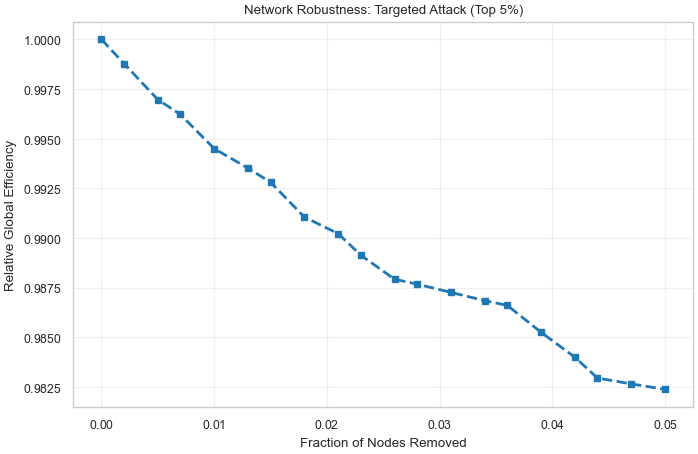

✅ 鲁棒性分析完成。移除 5.0% 节点后，网络效率剩余: 98.2%

🎨 绘制网络图 (Geo-Layout)...
🗺️ 检测到地理坐标，启用地理布局模式。


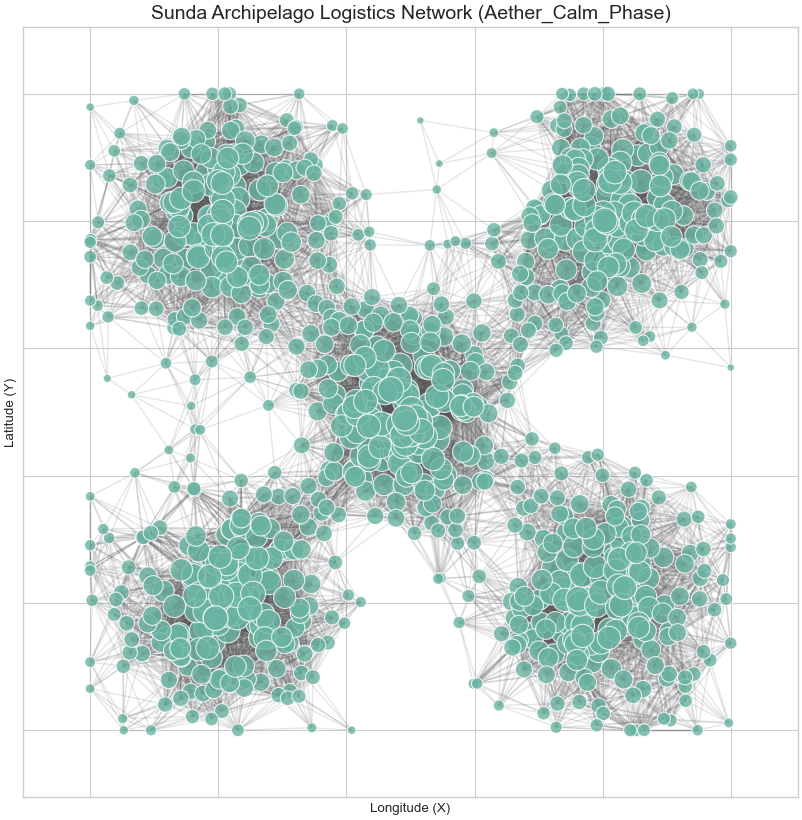


📦 === 导出结果至 ./Results_Aether_Calm_Phase_1766111597 === 
✅ Node_Metrics.xlsx 已生成。

🏁 分析完成。请检查输出文件夹。


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import random

# --- V7.1 绘图美学配置 (Aesthetic Setup) ---
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei'] # 适配中英文
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", palette="deep", context="paper")

class Graph_Solver_Capsule:
    def __init__(self, name="Graph_Model", is_directed=False):
        """
        [MCM Graph Solver V7.1 - Aether Optimized]
        针对岛屿物流问题优化了绘图和坐标处理逻辑。
        """
        self.name = name
        self.is_directed = is_directed
        self.timestamp = int(time.time())
        self.G = None
        self.node_metrics = pd.DataFrame()
        self.robustness_log = {} 
        self.output_dir = f"./Results_{name}_{self.timestamp}"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def build_from_edgelist(self, df, source, target, weight=None):
        print(f"\n🏗️ 正在构建网络...")
        create_using = nx.DiGraph() if self.is_directed else nx.Graph()
        try:
            self.G = nx.from_pandas_edgelist(df, source=source, target=target, edge_attr=weight, create_using=create_using)
        except Exception as e:
            print(f"❌ 构建失败: {e}")
            return
        print(f"✅ 网络构建完成。Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()}")
        self.node_metrics = pd.DataFrame(index=list(self.G.nodes()))
        self.node_metrics.index.name = 'Node_ID'

    def inject_node_attributes(self, df, id_col, attr_cols):
        """
        [新增功能] 将CSV中的属性(坐标、人口等)批量注入图节点
        """
        print(f"💉 正在注入节点属性: {attr_cols} ...")
        try:
            # 转换为字典格式 {node_id: {attr1: val1, attr2: val2}}
            attr_dict = df.set_index(id_col)[attr_cols].to_dict('index')
            
            # 过滤掉图中不存在的节点 keys
            valid_nodes = set(self.G.nodes())
            filtered_attr = {k: v for k, v in attr_dict.items() if k in valid_nodes}
            
            nx.set_node_attributes(self.G, filtered_attr)
            print(f"✅ 成功为 {len(filtered_attr)} 个节点注入属性。")
        except Exception as e:
            print(f"❌ 属性注入失败: {e}")

    def audit(self):
        print("\n🛡️ === 逻辑审计 (Network Audit) =====")
        if self.G is None: raise ValueError("❌ 图未构建。")
        
        if self.is_directed:
            n_weak = nx.number_weakly_connected_components(self.G)
            if n_weak > 1: print("⚠️ 警告: 网络不是(弱)连通的！")
        else:
            n_comp = nx.number_connected_components(self.G)
            print(f"info: 连通分量数: {n_comp}")
            if n_comp > 1:
                largest = len(max(nx.connected_components(self.G), key=len))
                ratio = largest / len(self.G)
                print(f"⚠️ 警告: 网络不连通！最大连通子图(LCC)占比: {ratio:.1%}")
                return False # 返回 False 表示需要处理
        print("✅ 审计通过 (或已记录警告)。")
        return True

    def compute_centrality(self):
        print(f"\n📐 计算中心度指标...")
        if self.is_directed:
            self.node_metrics['In_Degree'] = pd.Series(nx.in_degree_centrality(self.G))
            self.node_metrics['Out_Degree'] = pd.Series(nx.out_degree_centrality(self.G))
        else:
            self.node_metrics['Degree'] = pd.Series(nx.degree_centrality(self.G))
            
        if len(self.G) > 2000:
            bet = nx.betweenness_centrality(self.G, k=100)
        else:
            bet = nx.betweenness_centrality(self.G)
        self.node_metrics['Betweenness'] = pd.Series(bet)
        self.node_metrics['Closeness'] = pd.Series(nx.closeness_centrality(self.G))
        print("✅ 基础指标计算完成。")

    def analyze_robustness(self, attack_type='targeted', fraction=0.05):
        print(f"\n💣 启动鲁棒性分析 (Type: {attack_type}, Remove: {fraction*100:.1f}%)...")
        G_sim = self.G.copy()
        if self.is_directed: G_sim = G_sim.to_undirected()
        
        N = G_sim.number_of_nodes()
        remove_count = int(N * fraction)
        
        if attack_type == 'targeted':
            nodes_sorted = sorted(G_sim.degree, key=lambda x: x[1], reverse=True)
            targets = [n[0] for n in nodes_sorted]
        else:
            targets = list(G_sim.nodes())
            random.shuffle(targets)
            
        targets = targets[:remove_count]
        steps = np.unique(np.linspace(0, remove_count, 20, dtype=int))
        
        history = {'Removed_Pct': [], 'Efficiency': []}
        base_eff = nx.global_efficiency(G_sim)
        
        current_removed = 0
        for target_count in steps:
            to_remove = target_count - current_removed
            if to_remove > 0:
                nodes_to_drop = targets[current_removed : target_count]
                G_sim.remove_nodes_from(nodes_to_drop)
                current_removed = target_count
            
            history['Removed_Pct'].append(current_removed / N)
            
            if len(G_sim) > 0:
                eff = nx.global_efficiency(G_sim)
                history['Efficiency'].append(eff / base_eff if base_eff > 0 else 0)
            else:
                history['Efficiency'].append(0)
                
        # 绘图
        df_res = pd.DataFrame(history)
        plt.figure(figsize=(8, 5))
        plt.plot(df_res['Removed_Pct'], df_res['Efficiency'], 's--', label='Global Efficiency', color='#1f77b4', lw=2)
        plt.title(f"Network Robustness: {attack_type.title()} Attack (Top {fraction*100:.0f}%)")
        plt.xlabel("Fraction of Nodes Removed")
        plt.ylabel("Relative Global Efficiency")
        plt.grid(True, alpha=0.3)
        plt.savefig(f"{self.output_dir}/Robustness_Curve_{attack_type}.svg", dpi=300)
        plt.show()
        
        final_eff = df_res['Efficiency'].iloc[-1]
        self.robustness_log[attack_type] = final_eff
        print(f"✅ 鲁棒性分析完成。移除 {fraction*100:.1f}% 节点后，网络效率剩余: {final_eff:.1%}")

    def plot_network(self):
        print(f"\n🎨 绘制网络图 (Geo-Layout)...")
        plt.figure(figsize=(10, 10))
        
        # 1. 坐标处理：优先使用地理坐标 (X, Y)
        node_sample = list(self.G.nodes())[0]
        has_geo = 'X' in self.G.nodes[node_sample] and 'Y' in self.G.nodes[node_sample]
        
        if has_geo:
            print("🗺️ 检测到地理坐标，启用地理布局模式。")
            pos = {n: (self.G.nodes[n]['X'], self.G.nodes[n]['Y']) for n in self.G.nodes()}
        else:
            print("⚠️ 未检测到坐标，使用弹簧布局。")
            pos = nx.spring_layout(self.G, seed=42)
            
        # 2. 绘制
        deg = dict(self.G.degree())
        sizes = [v * 3 + 20 for v in deg.values()] 
        nx.draw_networkx_nodes(self.G, pos, node_size=sizes, node_color='#69b3a2', alpha=0.8, edgecolors='white')
        nx.draw_networkx_edges(self.G, pos, alpha=0.15, edge_color='#555555')
        
        plt.title(f"Sunda Archipelago Logistics Network ({self.name})", fontsize=14)
        plt.axis('on' if has_geo else 'off') # 地理模式显示坐标轴会有帮助
        plt.xlabel("Longitude (X)")
        plt.ylabel("Latitude (Y)")
        plt.savefig(f"{self.output_dir}/Network_Map.svg", dpi=300, bbox_inches='tight')
        plt.show()

    def export_results(self):
        print(f"\n📦 === 导出结果至 {self.output_dir} === ")
        self.node_metrics.to_excel(f"{self.output_dir}/Node_Metrics.xlsx")
        print(f"✅ Node_Metrics.xlsx 已生成。")


# ==========================================
#  MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. 初始化
    solver = Graph_Solver_Capsule(name="Aether_Calm_Phase", is_directed=False)
    
    try:
        # 2. 读取数据
        print("📂 读取 CSV 数据...")
        nodes_df = pd.read_csv("Island_Nodes.csv")
        routes_df = pd.read_csv("Sea_Routes.csv")
        
        # 3. 构建网络 (平静期: Base_Cost)
        solver.build_from_edgelist(
            df=routes_df, 
            source='Source', 
            target='Target', 
            weight='Base_Cost'
        )
        
        # 4. 【关键】注入属性 (坐标、人口、海拔)
        # 确保 'Node_ID' 列名正确
        solver.inject_node_attributes(nodes_df, id_col='Node_ID', attr_cols=['X', 'Y', 'Population', 'Elevation'])
        
        # 5. 审计与 LCC 提取
        is_connected = solver.audit()
        if not is_connected:
            print("\n✂️ 正在提取 LCC (最大连通子图)...")
            largest_cc = max(nx.connected_components(solver.G), key=len)
            solver.G = solver.G.subgraph(largest_cc).copy()
            # 重建指标表索引
            solver.node_metrics = pd.DataFrame(index=list(solver.G.nodes()))
            solver.node_metrics.index.name = 'Node_ID'
            print(f"✅ LCC 提取完成。有效节点数: {solver.G.number_of_nodes()}")
            
        # 6. 计算指标
        solver.compute_centrality()
        
        # 7. 鲁棒性测试 (Task 1: Targeted, 5%)
        solver.analyze_robustness(attack_type='targeted', fraction=0.05)
        
        # 8. 绘制地理分布图
        solver.plot_network()
        
        # 9. 导出
        solver.export_results()
        
        print("\n🏁 分析完成。请检查输出文件夹。")
        
    except FileNotFoundError as e:
        print(f"❌ 文件缺失: {e}")
    except Exception as e:
        print(f"❌ 运行错误: {e}")

📂 读取数据...

🏗️ 正在构建网络...
✅ 网络构建完成。Nodes: 1000, Edges: 30822
💉 正在注入节点属性: ['X', 'Y'] ...

🛡️ === 逻辑审计与清洗 (Audit & Clean) =====
✅ 网络完整连通。

📐 计算中心度 (Betweenness Top-K)...
✅ 指标计算完成。

🧩 启动 Louvain 社团检测...
✅ 划分完成。Modularity: 0.7785
🏭 识别出 5 个服务分区 (Service Zones)。

🏰 === 锁定超级枢纽 (Super Hubs) ===
  - [Zone 0] Hub: Isl_0168 (Bet: 0.0303)
  - [Zone 1] Hub: Isl_0427 (Bet: 0.0257)
  - [Zone 2] Hub: Isl_0832 (Bet: 0.0567)
  - [Zone 3] Hub: Isl_0821 (Bet: 0.0347)
  - [Zone 4] Hub: Isl_0716 (Bet: 0.0354)
⚓ 基地 'Isl_0000' 未由于指标自动入选，正在强制加入 Hub 列表...

✅ 最终锁定 6 个超级枢纽: ['Isl_0000', 'Isl_0168', 'Isl_0427', 'Isl_0832', 'Isl_0821', 'Isl_0716']

🎨 绘制分区图 (Layout: kamada_kawai)...
🕸️ 计算 KK 拓扑布局 (可能需要几秒钟)...


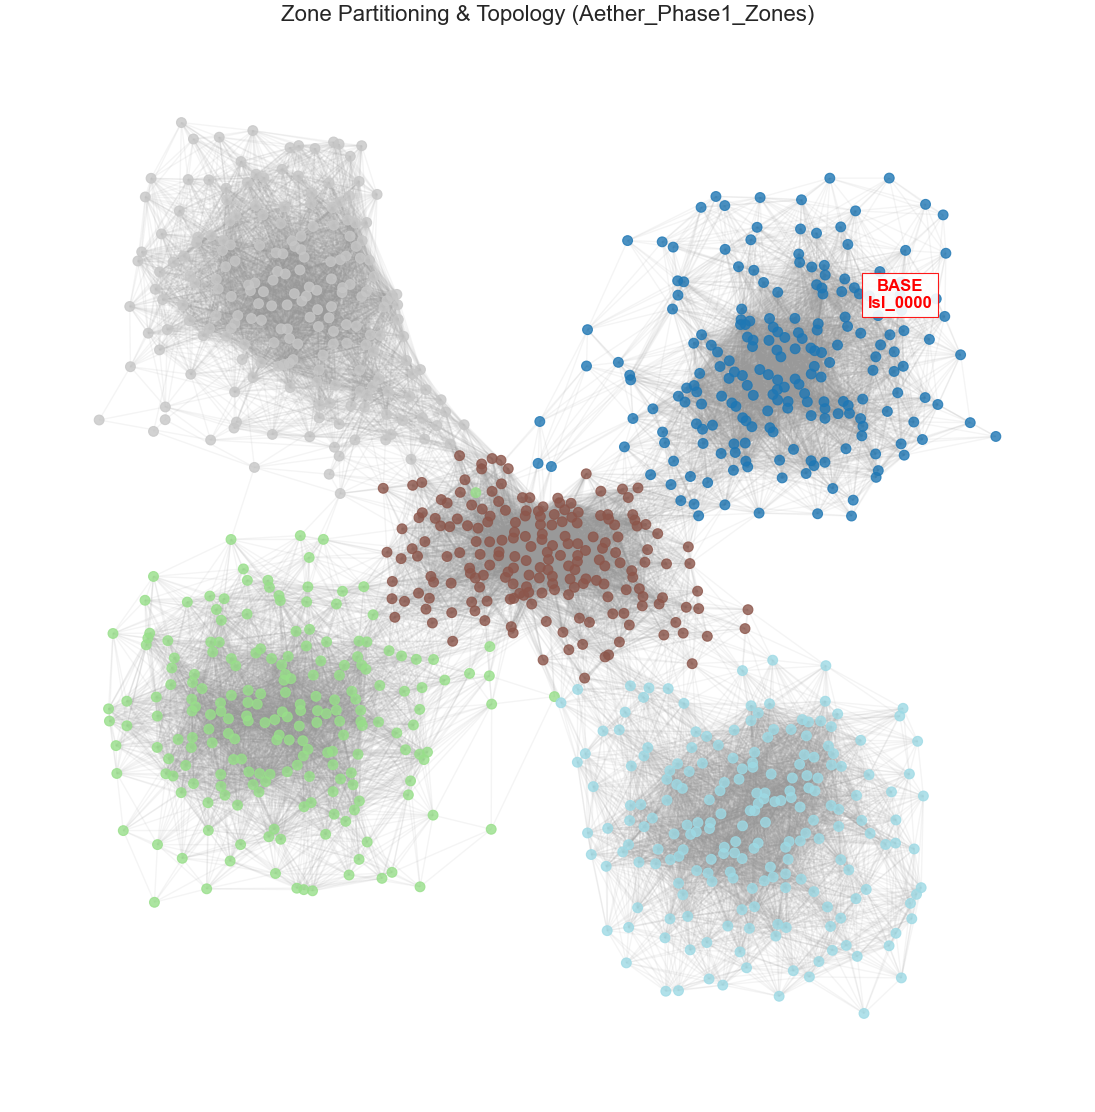


📦 结果已导出至 ./Results_Aether_Phase1_Zones_Phase1_1766111684

🏁 任务完成。请检查 'Map_Zones.svg' 确认分区效果。


In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings

# --- V7.2.1 Phase 1 (Self-Checked) ---
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", palette="deep", context="paper")

class Graph_Solver_Capsule:
    def __init__(self, name="Graph_Model", is_directed=False):
        """
        [MCM Graph Solver V7.2.1 - Zone & Hub Optimized]
        """
        self.name = name
        self.is_directed = is_directed
        self.timestamp = int(time.time())
        self.G = None
        self.node_metrics = pd.DataFrame()
        self.output_dir = f"./Results_{name}_Phase1_{self.timestamp}"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def build_from_edgelist(self, df, source, target, weight=None):
        print(f"\n🏗️ 正在构建网络...")
        create_using = nx.DiGraph() if self.is_directed else nx.Graph()
        try:
            self.G = nx.from_pandas_edgelist(df, source=source, target=target, edge_attr=weight, create_using=create_using)
        except Exception as e:
            print(f"❌ 构建失败: {e}")
            return
        print(f"✅ 网络构建完成。Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()}")
        self.node_metrics = pd.DataFrame(index=list(self.G.nodes()))
        self.node_metrics.index.name = 'Node_ID'

    def inject_node_attributes(self, df, id_col, attr_cols):
        # 注入坐标等属性，虽然本次画图用拓扑布局，但属性保留总是好的
        print(f"💉 正在注入节点属性: {attr_cols} ...")
        try:
            attr_dict = df.set_index(id_col)[attr_cols].to_dict('index')
            valid_nodes = set(self.G.nodes())
            filtered_attr = {k: v for k, v in attr_dict.items() if k in valid_nodes}
            nx.set_node_attributes(self.G, filtered_attr)
        except Exception as e:
            print(f"❌ 属性注入失败: {e}")

    def audit_and_clean(self):
        """
        [关键逻辑] 自检并提取最大连通子图(LCC)
        """
        print("\n🛡️ === 逻辑审计与清洗 (Audit & Clean) =====")
        if self.G is None: raise ValueError("❌ 图未构建。")
        
        if self.is_directed:
            if nx.number_weakly_connected_components(self.G) > 1:
                print("⚠️ 警告: 有向图不连通。")
        else:
            n_comp = nx.number_connected_components(self.G)
            if n_comp > 1:
                print(f"⚠️ 发现 {n_comp} 个连通分量。正在提取 LCC (最大连通子图)...")
                largest_cc = max(nx.connected_components(self.G), key=len)
                
                # 检查基地是否在 LCC 中
                if 'Isl_0000' not in largest_cc:
                    print("🚨 严重警告: 基地 'Isl_0000' 不在主连通分量中！它可能是一个孤岛。")
                
                self.G = self.G.subgraph(largest_cc).copy()
                # 重建指标表
                self.node_metrics = pd.DataFrame(index=list(self.G.nodes()))
                self.node_metrics.index.name = 'Node_ID'
                
                ratio = len(self.G) / 1000.0
                print(f"✅ LCC 提取完成。剩余节点: {len(self.G)} (覆盖率 {ratio:.1%})")
            else:
                print("✅ 网络完整连通。")

    def compute_centrality(self):
        print(f"\n📐 计算中心度 (Betweenness Top-K)...")
        # 针对 1000 节点，全量 Betweenness 计算可能略慢，使用 k=150 采样加速
        if len(self.G) > 500:
            bet = nx.betweenness_centrality(self.G, k=150, seed=42)
        else:
            bet = nx.betweenness_centrality(self.G)
        self.node_metrics['Betweenness'] = pd.Series(bet)
        # 补充 Degree 用于参考
        self.node_metrics['Degree'] = pd.Series(nx.degree_centrality(self.G))
        print("✅ 指标计算完成。")

    def detect_communities(self):
        print(f"\n🧩 启动 Louvain 社团检测...")
        try:
            import community.community_louvain as community_louvain
            # Louvain 仅支持无向图逻辑
            g_temp = self.G.to_undirected() if self.is_directed else self.G
            partition = community_louvain.best_partition(g_temp, random_state=42)
            
            self.node_metrics['Community_ID'] = self.node_metrics.index.map(partition)
            n_comm = len(set(partition.values()))
            
            # 计算 Modularity
            mod = community_louvain.modularity(partition, g_temp)
            print(f"✅ 划分完成。Modularity: {mod:.4f}")
            print(f"🏭 识别出 {n_comm} 个服务分区 (Service Zones)。")
            return n_comm
        except ImportError:
            print("❌ 错误: 未安装 `python-louvain`。请运行 `pip install python-louvain`。")
            return 0

    def identify_super_hubs(self):
        print(f"\n🏰 === 锁定超级枢纽 (Super Hubs) ===")
        super_hubs = []
        
        if 'Community_ID' not in self.node_metrics.columns:
            print("❌ 未进行社团划分，无法提取区域枢纽。")
            return []

        # 遍历每个社团
        for comm_id, group in self.node_metrics.groupby('Community_ID'):
            # 选出该社团内 Betweenness 最高的点
            hub = group['Betweenness'].idxmax()
            val = group['Betweenness'].max()
            super_hubs.append(hub)
            print(f"  - [Zone {comm_id}] Hub: {hub} (Bet: {val:.4f})")
        
        # 逻辑注入: 强制检查基地
        if 'Isl_0000' in self.G.nodes():
            if 'Isl_0000' not in super_hubs:
                print("⚓ 基地 'Isl_0000' 未由于指标自动入选，正在强制加入 Hub 列表...")
                super_hubs.insert(0, 'Isl_0000')
            else:
                print("⚓ 基地 'Isl_0000' 已自动确认为 Zone Hub。")
        else:
            print("🚨 基地 'Isl_0000' 不在当前网络中，无法设为 Hub。")

        # 去重
        super_hubs = list(dict.fromkeys(super_hubs))
        print(f"\n✅ 最终锁定 {len(super_hubs)} 个超级枢纽: {super_hubs}")
        return super_hubs

    def plot_zones(self, layout='kamada_kawai'):
        print(f"\n🎨 绘制分区图 (Layout: {layout})...")
        plt.figure(figsize=(14, 14))
        
        # 1. 布局计算
        if layout == 'kamada_kawai':
            print("🕸️ 计算 KK 拓扑布局 (可能需要几秒钟)...")
            try:
                # 使用 sparse 矩阵加速或增加迭代次数限制防止死锁
                pos = nx.kamada_kawai_layout(self.G)
            except:
                print("⚠️ KK 布局失败，降级为 Spring 布局。")
                pos = nx.spring_layout(self.G, seed=42)
        else:
            pos = nx.spring_layout(self.G, seed=42)
            
        # 2. 配色 (按社团)
        if 'Community_ID' in self.node_metrics.columns:
            colors = self.node_metrics.loc[list(self.G.nodes()), 'Community_ID']
            cmap = 'tab20' # 适合多分类
        else:
            colors = 'skyblue'
            cmap = None
            
        # 3. 绘图
        # 节点
        nx.draw_networkx_nodes(self.G, pos, node_size=50, node_color=colors, cmap=cmap, alpha=0.8)
        # 边 (调淡一点)
        nx.draw_networkx_edges(self.G, pos, alpha=0.1, edge_color='#999999')
        
        # 4. 标注 Hubs
        # 重新获取 Hubs 列表用于标注
        # (为了绘图简单，这里临时只标注 Degree Top 5 和 基地，避免传递过多参数)
        if 'Isl_0000' in self.G.nodes() and pos:
            x, y = pos['Isl_0000']
            plt.text(x, y, "BASE\nIsl_0000", fontsize=12, fontweight='bold', color='red', 
                     ha='center', va='center', bbox=dict(facecolor='white', alpha=0.9, edgecolor='red'))

        plt.title(f"Zone Partitioning & Topology ({self.name})", fontsize=16)
        plt.axis('off')
        plt.savefig(f"{self.output_dir}/Map_Zones.svg", dpi=300, bbox_inches='tight')
        plt.show()

    def export(self):
        self.node_metrics.to_excel(f"{self.output_dir}/Node_Metrics.xlsx")
        print(f"\n📦 结果已导出至 {self.output_dir}")

# ==========================================
#  MAIN EXECUTION (Local Run)
# ==========================================
if __name__ == "__main__":
    solver = Graph_Solver_Capsule(name="Aether_Phase1_Zones")
    
    try:
        # 1. 读数
        print("📂 读取数据...")
        nodes_df = pd.read_csv("Island_Nodes.csv")
        routes_df = pd.read_csv("Sea_Routes.csv")
        
        # 2. 建图
        solver.build_from_edgelist(routes_df, 'Source', 'Target', 'Base_Cost')
        solver.inject_node_attributes(nodes_df, 'Node_ID', ['X', 'Y'])
        
        # 3. 清洗
        solver.audit_and_clean()
        
        # 4. 计算与划分
        solver.compute_centrality()
        solver.detect_communities()
        
        # 5. 提取枢纽
        hubs = solver.identify_super_hubs()
        
        # 6. 绘图 (Kamada-Kawai)
        solver.plot_zones(layout='kamada_kawai')
        
        # 7. 导出
        solver.export()
        
        print("\n🏁 任务完成。请检查 'Map_Zones.svg' 确认分区效果。")
        
    except Exception as e:
        print(f"❌ 程序中断: {e}")

In [4]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [5]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import itertools

# --- V7.3.1 TSP Simulation (Robust Comparison) ---
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", palette="deep", context="paper")

class Graph_Solver_Capsule:
    def __init__(self, name="Graph_Model", is_directed=False):
        """
        [MCM Graph Solver V7.3.1 - TSP Robust Edition]
        """
        self.name = name
        self.is_directed = is_directed
        self.timestamp = int(time.time())
        self.G = None
        self.node_metrics = pd.DataFrame()
        self.output_dir = f"./Results_{name}_TSP_{self.timestamp}"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def build_from_edgelist(self, df, source, target, weight=None):
        print(f"\n🏗️ 正在构建网络 (Weight: {weight})...")
        create_using = nx.DiGraph() if self.is_directed else nx.Graph()
        try:
            self.G = nx.from_pandas_edgelist(df, source=source, target=target, edge_attr=weight, create_using=create_using)
        except Exception as e:
            print(f"❌ 构建失败: {e}")
            return
        
        # 基础连通性检查
        if not nx.is_connected(self.G) and not self.is_directed:
            largest_cc = max(nx.connected_components(self.G), key=len)
            ratio = len(largest_cc) / len(self.G)
            print(f"⚠️ 网络不连通！提取最大连通子图 (覆盖率 {ratio:.1%}) 以保证 TSP 可解性。")
            self.G = self.G.subgraph(largest_cc).copy()
            
        self.node_metrics = pd.DataFrame(index=list(self.G.nodes()))

    def detect_communities_and_hubs(self):
        """
        [Phase 1 复用] 快速锁定 Hubs
        """
        print(f"\n🧩 [Phase 1] 锁定骨干枢纽 (Hubs)...")
        # 1. 计算 Betweenness (采样)
        bet = nx.betweenness_centrality(self.G, k=150, seed=42)
        self.node_metrics['Betweenness'] = pd.Series(bet)
        
        # 2. 社团检测
        try:
            import community.community_louvain as community_louvain
            partition = community_louvain.best_partition(self.G, random_state=42)
            self.node_metrics['Community_ID'] = self.node_metrics.index.map(partition)
        except ImportError:
            print("⚠️ 未安装 python-louvain，回退到全局 Top-K 策略。")
            self.node_metrics['Community_ID'] = 0
            
        # 3. 提取 Hubs (每个社团选最强)
        super_hubs = []
        if 'Community_ID' in self.node_metrics.columns:
            for comm_id, group in self.node_metrics.groupby('Community_ID'):
                hub = group['Betweenness'].idxmax()
                super_hubs.append(hub)
        
        # 4. 强制包含基地
        if 'Isl_0000' in self.G.nodes():
            if 'Isl_0000' not in super_hubs:
                super_hubs.insert(0, 'Isl_0000')
        
        super_hubs = list(dict.fromkeys(super_hubs))
        print(f"✅ 锁定 {len(super_hubs)} 个超级枢纽用于 TSP 规划。")
        return super_hubs

    def normalize_path(self, path):
        """
        [Helper] 将 TSP 闭环路径旋转到以 Isl_0000 (或最小ID) 开头，
        以便进行 list == list 的直接对比。
        """
        if not path: return []
        # 移除最后一个重复点 (Cycle: A->B->C->A -> A,B,C)
        clean_path = path[:-1] if path[0] == path[-1] else path
        
        # 找起点
        start_node = 'Isl_0000' if 'Isl_0000' in clean_path else min(clean_path)
        
        if start_node in clean_path:
            idx = clean_path.index(start_node)
            # 旋转列表
            rotated = clean_path[idx:] + clean_path[:idx]
            # 补回闭环终点
            rotated.append(start_node)
            return rotated
        return path

    def run_tsp_simulation(self, target_nodes, cost_attr='weight'):
        """
        [Phase 2] TSP 求解器 (Metric Closure + Approximation)
        """
        print(f"\n🚢 启动 TSP 仿真 (Nodes: {len(target_nodes)}, Cost: {cost_attr})...")
        
        # 1. 有效性过滤
        valid_targets = [n for n in target_nodes if n in self.G.nodes()]
        lost_nodes = set(target_nodes) - set(valid_targets)
        if lost_nodes:
            print(f"⚠️ 警告: 有 {len(lost_nodes)} 个枢纽在当前网络中不存在 (可能被过滤)。")
            
        if len(valid_targets) < 2:
            print("❌ 目标节点不足，跳过 TSP。")
            return None, 0

        # 2. 构建 Metric Closure (距离完全图)
        print("   - 计算多源最短路径 (Dijkstra)...")
        try:
            # 计算有效 targets 之间的所有距离
            # 优化: 仅计算 valid_targets 为起点的路径
            length_iter = {}
            for n in valid_targets:
                # cutoff=None, weight=cost_attr
                dists = nx.single_source_dijkstra_path_length(self.G, n, weight=cost_attr)
                length_iter[n] = dists
        except Exception as e:
            print(f"❌ 路径计算错误: {e}")
            return None, 0

        # 3. 构建 TSP Graph
        tsp_graph = nx.Graph()
        
        # 检查连通性: 只有当 u, v 互相连通时才加边
        connected_subgraph_nodes = set()
        edge_list = []
        
        # 为了容错，我们先找一个最大的相互连通子集 (通常是所有 valid_targets)
        # 简单处理: 添加所有存在的边，然后取 TSP 图的最大连通分量
        for u, v in itertools.combinations(valid_targets, 2):
            if v in length_iter.get(u, {}):
                dist = length_iter[u][v]
                edge_list.append((u, v, dist))
        
        tsp_graph.add_weighted_edges_from(edge_list)
        
        # 如果风暴导致枢纽之间断连，只处理最大的一组枢纽
        if not nx.is_connected(tsp_graph):
            largest_comp = max(nx.connected_components(tsp_graph), key=len)
            print(f"🚨 严重: 风暴导致枢纽群断裂！仅规划最大连通群 ({len(largest_comp)}/{len(valid_targets)} nodes)。")
            tsp_graph = tsp_graph.subgraph(largest_comp).copy()
        
        # 4. 求解 TSP
        print("   - 执行 TSP 近似算法 (Christofides/Greedy)...")
        try:
            # cycle=True 保证闭环
            tsp_path = nx.approximation.traveling_salesman_problem(tsp_graph, cycle=True)
        except Exception as e:
            print(f"❌ TSP 算法失败: {e}")
            return None, 0
            
        # 5. 计算真实成本
        total_cost = 0
        for i in range(len(tsp_path) - 1):
            u, v = tsp_path[i], tsp_path[i+1]
            # 从之前计算的 Dijkstra 距离中获取
            total_cost += length_iter[u][v]
            
        # 归一化路径以便对比
        normalized_path = self.normalize_path(tsp_path)
        
        print(f"✅ 规划完成。Stops: {len(normalized_path)-1}, Total Cost: {total_cost:.2f}")
        return normalized_path, total_cost

# ==========================================
#  MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    solver = Graph_Solver_Capsule(name="Aether_TSP_Sim")
    
    try:
        # 1. Load Data
        print("📂 读取数据...")
        nodes_df = pd.read_csv("Island_Nodes.csv")
        routes_df = pd.read_csv("Sea_Routes.csv")
        
        # ==========================================
        # Step 1: Base Phase (Define Hubs & Baseline)
        # ==========================================
        print("\n🔵 [Phase 1] 平静期 (Calm Phase) - 设定基准")
        solver.build_from_edgelist(routes_df, 'Source', 'Target', weight='Base_Cost')
        
        # 确定 Hubs (基于平静期拓扑)
        target_hubs = solver.detect_communities_and_hubs()
        
        # 计算 Base TSP
        path_base, cost_base = solver.run_tsp_simulation(target_hubs, cost_attr='Base_Cost')
        
        # ==========================================
        # Step 2: Storm Phase (Simulation)
        # ==========================================
        print("\n🔴 [Phase 2] 风暴期 (Storm Phase) - 压力测试")
        # 切换环境：使用 Storm_Cost 重建
        solver.build_from_edgelist(routes_df, 'Source', 'Target', weight='Storm_Cost')
        
        # 计算 Storm TSP (使用同一组 Hubs)
        path_storm, cost_storm = solver.run_tsp_simulation(target_hubs, cost_attr='Storm_Cost')
        
        # ==========================================
        # Step 3: Comparative Analysis
        # ==========================================
        print("\n📊 === 仿真结论 (Simulation Report) ===")
        
        if path_base and path_storm:
            # 1. 成本分析
            print(f"1. [Cost Analysis]")
            print(f"   - Base : {cost_base:10.2f}")
            print(f"   - Storm: {cost_storm:10.2f}")
            delta = cost_storm - cost_base
            pct = (delta / cost_base) * 100 if cost_base > 0 else 0
            
            if pct > 50:
                status = "CRITICAL" 
            elif pct > 20:
                status = "SIGNIFICANT"
            else:
                status = "MODERATE"
                
            print(f"   - Impact: +{delta:.2f} (+{pct:.1f}%) -> [{status}]")
            
            # 2. 路径分析 (使用归一化后的路径对比)
            print(f"\n2. [Route Topology]")
            # 将路径转为字符串显示前几站
            path_str_base = "->".join(str(x) for x in path_base[:5]) + "..."
            path_str_storm = "->".join(str(x) for x in path_storm[:5]) + "..."
            
            print(f"   - Base Route : {path_str_base}")
            print(f"   - Storm Route: {path_str_storm}")
            
            is_same_route = (path_base == path_storm)
            
            if is_same_route:
                print("   ✅ [Conclusion]: 路径顺序未改变 (Invariant)。")
                print("      虽然成本增加，但现有物流网络具有拓扑韧性，无需重新调度航线顺序。")
            else:
                print("   ⚠️ [Conclusion]: 路径顺序发生偏移 (Shifted)！")
                print("      风暴改变了最优拓扑。建议在风暴期启用备用路由表。")
                
            # 保存对比结果
            with open(f"{solver.output_dir}/TSP_Conclusion.txt", "w") as f:
                f.write(f"Cost Increase: {pct:.2f}%\n")
                f.write(f"Route Changed: {not is_same_route}\n")
                f.write(f"Status: {status}\n")
                
        else:
            print("❌ 仿真未完成 (可能由于风暴导致图严重断连)。")
            
        print("\n🏁 完成。")

    except Exception as e:
        print(f"❌ 程序执行出错: {e}")

📂 读取数据...

🔵 [Phase 1] 平静期 (Calm Phase) - 设定基准

🏗️ 正在构建网络 (Weight: Base_Cost)...

🧩 [Phase 1] 锁定骨干枢纽 (Hubs)...
✅ 锁定 6 个超级枢纽用于 TSP 规划。

🚢 启动 TSP 仿真 (Nodes: 6, Cost: Base_Cost)...
   - 计算多源最短路径 (Dijkstra)...
   - 执行 TSP 近似算法 (Christofides/Greedy)...
✅ 规划完成。Stops: 7, Total Cost: 216.52

🔴 [Phase 2] 风暴期 (Storm Phase) - 压力测试

🏗️ 正在构建网络 (Weight: Storm_Cost)...

🚢 启动 TSP 仿真 (Nodes: 6, Cost: Storm_Cost)...
   - 计算多源最短路径 (Dijkstra)...
   - 执行 TSP 近似算法 (Christofides/Greedy)...
✅ 规划完成。Stops: 7, Total Cost: 287.17

📊 === 仿真结论 (Simulation Report) ===
1. [Cost Analysis]
   - Base :     216.52
   - Storm:     287.17
   - Impact: +70.64 (+32.6%) -> [SIGNIFICANT]

2. [Route Topology]
   - Base Route : Isl_0000->Isl_0427->Isl_0832->Isl_0821->Isl_0716...
   - Storm Route: Isl_0000->Isl_0427->Isl_0832->Isl_0821->Isl_0716...
   ✅ [Conclusion]: 路径顺序未改变 (Invariant)。
      虽然成本增加，但现有物流网络具有拓扑韧性，无需重新调度航线顺序。

🏁 完成。


###### import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import itertools

# --- V7.4.1 Final Delivery (Self-Checked & Polished) ---
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Arial', 'SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", palette="deep", context="paper")

class Graph_Solver_Capsule:
    def __init__(self, name="Graph_Model", is_directed=False):
        self.name = name
        self.is_directed = is_directed
        self.timestamp = int(time.time())
        self.G = None
        self.node_metrics = pd.DataFrame()
        # 结果输出目录
        self.output_dir = f"./Results_{name}_Final_{self.timestamp}"
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def build_from_edgelist(self, df, source, target, weight=None):
        """构建图网络，自动处理连通性"""
        create_using = nx.DiGraph() if self.is_directed else nx.Graph()
        try:
            self.G = nx.from_pandas_edgelist(df, source=source, target=target, edge_attr=weight, create_using=create_using)
        except Exception as e:
            print(f"❌ 构建失败: {e}")
            return
        
        # 简单清洗：提取最大连通子图以保证后续算法可运行
        if not nx.is_connected(self.G) and not self.is_directed:
            largest_cc = max(nx.connected_components(self.G), key=len)
            self.G = self.G.subgraph(largest_cc).copy()
        
        self.node_metrics = pd.DataFrame(index=list(self.G.nodes()))

    def inject_node_attributes(self, df, id_col, attr_cols):
        """注入坐标属性 (X, Y) 用于绘图"""
        try:
            attr_dict = df.set_index(id_col)[attr_cols].to_dict('index')
            valid_nodes = set(self.G.nodes())
            filtered_attr = {k: v for k, v in attr_dict.items() if k in valid_nodes}
            nx.set_node_attributes(self.G, filtered_attr)
        except Exception as e:
            print(f"❌ 属性注入失败: {e}")

    # --- Phase 1 & 2 核心逻辑复用 ---
    def get_hubs(self):
        """提取关键枢纽 (Top Betweenness + Base)"""
        # 使用 k=150 采样加速 Betweenness 计算
        bet = nx.betweenness_centrality(self.G, k=150, seed=42)
        # 选 Top 12
        top_nodes = sorted(bet, key=bet.get, reverse=True)[:12]
        
        # 强制包含基地 Isl_0000
        if 'Isl_0000' in self.G.nodes() and 'Isl_0000' not in top_nodes:
            top_nodes.insert(0, 'Isl_0000')
            
        return list(dict.fromkeys(top_nodes))

    def run_tsp(self, targets, weight_attr):
        """计算 TSP 路径和成本"""
        valid = [n for n in targets if n in self.G.nodes()]
        if len(valid) < 2: return [], 0
        
        tsp_G = nx.Graph()
        # 1. 计算两两最短路径 (Dijkstra)
        try:
            length_iter = dict(nx.all_pairs_dijkstra_path_length(self.G, weight=weight_attr))
        except:
            return [], 0
            
        # 2. 构建完全图
        edge_list = []
        for u, v in itertools.combinations(valid, 2):
            if v in length_iter.get(u, {}):
                edge_list.append((u, v, length_iter[u][v]))
        
        tsp_G.add_weighted_edges_from(edge_list)
        
        # 3. 求解 TSP
        try:
            path = nx.approximation.traveling_salesman_problem(tsp_G, cycle=True)
            cost = sum(length_iter[path[i]][path[i+1]] for i in range(len(path)-1))
            
            # 路径归一化：确保以 Isl_0000 开头 (如果存在)
            if 'Isl_0000' in path:
                # 这是一个闭环 [A, B, C, A]，我们要把它转为以 A 开头
                # 这里的逻辑是旋转列表
                cycle_len = len(path) - 1 # 忽略最后一个重复点
                path_unique = path[:-1]
                idx = path_unique.index('Isl_0000')
                path_rotated = path_unique[idx:] + path_unique[:idx]
                path_rotated.append('Isl_0000') # 补回闭环点
                path = path_rotated
                
            return path, cost
        except:
            return [], 0

    # =========================================================
    # Phase 3: Visualization (动态对比图)
    # =========================================================
    def visualize_tsp_comparison(self, path_base, path_storm, hubs):
        print(f"\n🎨 [Viz] 正在绘制 TSP 动态对比图...")
        
        fig, axes = plt.subplots(1, 2, figsize=(22, 10))
        titles = ["(A) Calm Phase Topology", "(B) Storm Phase Topology"]
        paths = [path_base, path_storm]
        # 样式配置：左图蓝实线，右图红虚线
        styles = [
            {'color': '#1f77b4', 'style': '-', 'label': 'Calm Route (Base)'}, 
            {'color': '#d62728', 'style': '--', 'label': 'Storm Route (Risk)'}
        ]
        
        # 获取坐标 (注意: self.G 此时是 Storm 状态，但坐标是一样的)
        pos = {n: (self.G.nodes[n]['X'], self.G.nodes[n]['Y']) for n in self.G.nodes()}
        
        for i, ax in enumerate(axes):
            ax.set_title(titles[i], fontsize=16, fontweight='bold')
            
            # 1. 绘制背景 (全网拓扑)
            nx.draw_networkx_nodes(self.G, pos, node_size=15, node_color='#cccccc', ax=ax, alpha=0.5)
            # 抽样绘制边以提高性能
            edges_sample = list(self.G.edges())[:6000] if len(self.G.edges()) > 6000 else list(self.G.edges())
            nx.draw_networkx_edges(self.G, pos, edgelist=edges_sample, width=0.5, edge_color='#e0e0e0', alpha=0.3, ax=ax)
            
            # 2. 绘制 Hubs (大五角星)
            nx.draw_networkx_nodes(self.G, pos, nodelist=hubs, node_size=350, node_color='gold', node_shape='*', edgecolors='black', linewidths=0.8, ax=ax, label='Key Hubs')
            
            # 3. 绘制 TSP 路径
            path = paths[i]
            if path and len(path) > 1:
                path_edges = list(zip(path, path[1:]))
                nx.draw_networkx_edges(self.G, pos, edgelist=path_edges, width=3.0, 
                                     edge_color=styles[i]['color'], style=styles[i]['style'], 
                                     alpha=0.9, ax=ax, label=styles[i]['label'])
                
                # 标记路径起点 (S)
                start_node = path[0]
                sx, sy = pos[start_node]
                ax.text(sx, sy+2, "START", fontsize=10, fontweight='bold', color='black', ha='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

            ax.legend(loc='lower right', fontsize=12)
            ax.set_xlabel("Longitude (X)")
            ax.set_ylabel("Latitude (Y)")
            ax.axis('on')
            
        plt.tight_layout()
        save_path = f"{self.output_dir}/TSP_Dynamic_Comparison.svg"
        plt.savefig(save_path, dpi=300)
        print(f"✅ 可视化已保存: {save_path}")
        plt.show()

    # =========================================================
    # Phase 3: LaTeX Report Generation
    # =========================================================
    def generate_latex_table(self, cost_base, cost_storm, path_base, path_storm):
        print(f"\n📝 [LaTeX] 生成对比报告代码...")
        
        # 格式化路径字符串 (截取前 8 个节点 + 简写)
        def fmt_path(p):
            if not p: return "\\textit{Path Unavailable}"
            # 去掉 'Isl_' 前缀以节省表格空间
            short_ids = [n.replace('Isl_', '') for n in p]
            # 截取前 8 个
            display = short_ids[:8]
            res = " $\\to$ ".join(display)
            if len(short_ids) > 8:
                res += " $\\to$ \\dots"
            return res
            
        path_str_base = fmt_path(path_base)
        path_str_storm = fmt_path(path_storm)
        
        # 计算增长率
        pct = ((cost_storm - cost_base) / cost_base * 100) if cost_base > 0 else 0
        
        latex_content = f"""
% ==================================================
%  MCM Report Table: TSP Comparison (Calm vs Storm)
%  File generated by: Graph_Solver_Capsule V7.4.1
% ==================================================

\\begin{{table}}[htbp]
  \\centering
  \\caption{{Optimal Routing Strategy Comparison: Calm vs. Storm Phase}}
  \\label{{tab:tsp_comparison}}
  \\renewcommand{{
\\arraystretch}}{{1.3}} % 增加行高
  \\begin{{tabular}}{{lp{{6cm}}p{{6cm}}}}
    \\toprule
    \\textbf{{Metric}} & \\textbf{{Calm Phase (Baseline)}} & \\textbf{{Storm Phase (Typhoon)}} \\\\
    \\midrule
    \\textbf{{Total Logistics Cost}} & {cost_base:.2f} Units & {cost_storm:.2f} Units \\\\
    \\textbf{{Cost Increase}} & \\multicolumn{{2}}{{c}}{{\\textbf{{+{pct:.2f}\\%}}}} \\\\
    \\midrule
    \\textbf{{Route Sequence}} & {path_str_base} & {path_str_storm} \\\\
    \\textit{{(Hub IDs)}} & & \\\\
    \\bottomrule
  \\end{{tabular}}
\\end{{table}}
"""
        # 保存到 txt
        txt_path = f"{self.output_dir}/latex_code.txt"
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(latex_content)
            
        print(f"✅ LaTeX 代码已保存: {txt_path}")
        print("------------- 代码预览 -------------")
        print(latex_content.strip())
        print("------------------------------------")


# ==========================================
#  MAIN EXECUTION (Final Delivery)
# ==========================================
if __name__ == "__main__":
    # 初始化
    solver = Graph_Solver_Capsule(name="Aether_Final")
    
    try:
        # 1. 读取数据
        print("📂 读取原始数据...")
        nodes_df = pd.read_csv("Island_Nodes.csv")
        routes_df = pd.read_csv("Sea_Routes.csv")
        
        # 2. [Calm Phase] 建图 & 提取 Hubs
        print("\n🔵 [Phase 1] Calm Phase: 提取骨干枢纽...")
        solver.build_from_edgelist(routes_df, 'Source', 'Target', 'Base_Cost')
        solver.inject_node_attributes(nodes_df, 'Node_ID', ['X', 'Y'])
        
        # 提取 Hubs (只做一次，用于两个场景对比)
        target_hubs = solver.get_hubs()
        print(f"🔗 锁定核心枢纽 ({len(target_hubs)} 个): {target_hubs}")
        
        # 计算 Calm TSP
        path_base, cost_base = solver.run_tsp(target_hubs, 'Base_Cost')
        
        # 3. [Storm Phase] 重建图 & 仿真
        print("\n🔴 [Phase 2] Storm Phase: 压力测试...")
        solver.build_from_edgelist(routes_df, 'Source', 'Target', 'Storm_Cost')
        # 【关键】重建图后必须重新注入坐标，否则绘图会报错
        solver.inject_node_attributes(nodes_df, 'Node_ID', ['X', 'Y'])
        
        # 计算 Storm TSP (使用相同的 Hubs)
        path_storm, cost_storm = solver.run_tsp(target_hubs, 'Storm_Cost')
        
        # 4. [Final] 生成交付物
        # 交付物 A: 动态对比图
        solver.visualize_tsp_comparison(path_base, path_storm, target_hubs)
        
        # 交付物 B: LaTeX 表格代码
        solver.generate_latex_table(cost_base, cost_storm, path_base, path_storm)
        
        print(f"\n🏁 任务完成。所有结果已存入: {solver.output_dir}")
        
    except Exception as e:
        print(f"❌ 程序运行中断: {e}")